# Topic: Identifying Helpful and Representative Reviews Using Machine Learning

### Objective
This project aims to assess the helpfulness of product reviews on Amazon by combining textual analysis, metadata engineering, and machine learning. Specifically, we focus on:

- Predicting whether a review is helpful (HelpfulBinary) using XGBClassifier.
- Identifying the most representative review per product using BERT-based semantic similarity.
- Evaluating whether these representative reviews tend to be helpful

### Dataset
The dataset consists of Amazon product reviews, with fields including review text, timestamp, score, and helpfulness information (numerator and denominator). Reviews without any helpfulness votes were flagged and separated for later prediction.
https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

### Key Steps
1. Data Cleaning and Feature Engineering

- Created a helpfulness_ratio (numerator / denominator).

- Flagged reviews with zero denominator as no_helpfulness for later use.

- Generated a binary label HelpfulBinary (1 if ratio > 0.5, else 0).

- Created recency weights based on review timestamps.

- Cleaned review text using tokenization, stopword removal, and lemmatization.

2. Representativeness Scoring

- Used a pre-trained BERT model to compute cosine similarity of each review against others within the same product.

- Assigned a cosine_avg_sim score to quantify how representative a review is.

- Selected the most representative review per product based on this score.

3. Dimensionally reduction -- SVD
- Compress the TF-IDF features into 100 dimensions using TruncatedSVD

- Apply standardization (StandardScaler) to ensure that all features are on the same scale.


4. Model Training

- Trained an XGBoost classifier to predict HelpfulBinary using TF-IDF text features, cosine_avg_sim, and recency_weight.
- Built scale_pos_weight to solve imbalanced problem

- For data with SVD, achieved approximately 85% accuracy on the test set.
- For data without SVD, achieved approximately 79% accuracy on the test set.

5. Post-Training Analysis

- Applied the trained model_svd to reviews that lacked helpfulness labels (zero denominator).

- Analyzed whether the most representative reviews (for each product) were predicted to be helpful.

- Compared the helpfulness of Most representative reviews, all reviews, and random reviews (1 per product)

- Representative reviews are truly more useful

### Key Takeaways

- Semantic similarity is a strong signal of review quality.
- Machine learning can effectively predict helpfulness, even in the absence of user votes.
- Most representative reviews are not only central in meaning—but often truly helpful.

### Conclusion
This project demonstrates a hybrid approach: combining semantic similarity (BERT-based) with traditional supervised learning to enhance review helpfulness prediction. It also highlights the practical value of identifying "representative reviews" to improve user experience in platforms like e-commerce or review aggregators.

## import and install pakages

In [5]:
#!pip install datasets -U transformers -U sentence_transformers pandas scikit-learn nltk xgboost -U transformers

In [4]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import hstack

# for S3
import hashlib
import boto3
from botocore.exceptions import NoCredentialsError, PartialCredentialsError

## for cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from tqdm import tqdm
import csv
import os

## Upload to S3

In [3]:
# Initialize S3 Client
s3 = boto3.client("s3")
bucket_name = "is597-group10"  # bucket name
region = "us-east-1"  # AWS region

In [4]:
def print_result_1(message):
    print("=" * 80)
    print(message)
    print("=" * 80)

In [5]:
file_path = "Reviews.csv"  # Replace with a local file path
object_key = "data/Reviews.csv"

# Upload an Object
try:
    s3.upload_file(file_path, bucket_name, object_key)
    print_result_1(f"File '{file_path}' uploaded as '{object_key}'.")
except FileNotFoundError:
    print("The file was not found.")
except NoCredentialsError:
    print("Credentials not available.")

File 'Reviews.csv' uploaded as 'data/Reviews.csv'.


## Fetches data directly from S3 to use cleaned data

In [6]:
download_path = "Reviews.csv"
object_key = "data/Reviews.csv"
try:
    s3.download_file(bucket_name, object_key, download_path)
    print(f"File '{object_key}' downloaded to '{download_path}'.")
except Exception as e:
    print(f"Error downloading file: {e}")

File 'data/Reviews.csv' downloaded to 'Reviews.csv'.


## Data Loading and Cleaning

We begin by loading the dataset, handling duplicates, and converting the review timestamps into a numerical format for recency analysis.


In [7]:
df = pd.read_csv('Reviews.csv')

In [8]:
#Missing values
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [9]:
# Filling missing values
df['ProfileName'].fillna('Unavailable')
df.drop(columns='Summary',inplace=True)

In [10]:
# remove duplications
df.drop_duplicates(inplace=True)
df = df.dropna(subset=['Text'])

### Recency Weight Calculation

To prioritize newer reviews, we compute a **recency weight** based on the date of each review:

- First, calculate the number of days since each review:

  ![formula1](formula1.png)

- Then, compute the recency weight:

  ![formula1](formula2.png)

**Interpretation:**
- **Newer reviews** (smaller days\_since) will have a **higher weight**.
- **Older reviews** (larger days\_since) will have a **lower weight**.
- Adding \( +1 \) in the denominator prevents division by zero and stabilizes the calculation.

This method ensures that **recent reviews contribute more** when training and prediction models.


In [11]:
# time preprocessing
df['Time'] = pd.to_datetime(df['Time'], unit='s')
latest_date = df['Time'].max()
df['days_since'] = (latest_date - df['Time']).dt.days
df['recency_weight'] = 1 / (df['days_since'] + 1)

In [12]:
# make ReviewIdx for furthering usage
df['ReviewIdx'] = df.groupby("ProductId").cumcount()

# We create a helpfulness ratio and define a binary label `HelpfulBinary`. Reviews with zero helpfulness votes are also flagged.
df['helpfulness_ratio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
df['HelpfulBinary'] = (df['helpfulness_ratio'] > 0.5).astype(int)



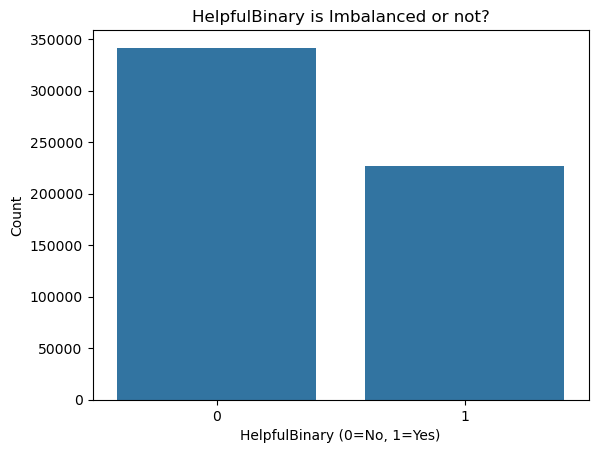

In [13]:
sns.countplot(data=df, x='HelpfulBinary')
plt.title("HelpfulBinary is Imbalanced or not?")
plt.xlabel("HelpfulBinary (0=No, 1=Yes)")
plt.ylabel("Count")
plt.show()


It's slightly imbalanced, we'll solve imbalanced problem in model training step.

In [14]:
df[df['HelpfulnessDenominator'] > 0]["HelpfulBinary"].value_counts()

HelpfulBinary
1    226666
0     71736
Name: count, dtype: int64

In [15]:
len(df)

568454

In [16]:
len(df["ProductId"].unique())

74258

In [17]:
# Among 568454 products review, has 74258 products, but only 24739 products have more than three reviews
(df["ProductId"].value_counts() > 3).sum()

24739

It suggests that among 568454 products review, has 74258 products, but only 24739 products have more than three reviews

In [18]:
df = df[['ProductId', 'Text', 'helpfulness_ratio', 'recency_weight', 'Time', 'HelpfulBinary', 'ReviewIdx']]
#df_unlabeled = df_unlabeled[['ProductId', 'Text', 'recency_weight', 'Time', 'ReviewIdx']].dropna()
df.head()

,ProductId,Text,helpfulness_ratio,recency_weight,Time,HelpfulBinary,ReviewIdx
0,B001E4KFG0,I have bought several of the Vitality canned d...,1.0,0.001821,2011-04-27,1,0
1,B00813GRG4,Product arrived labeled as Jumbo Salted Peanut...,NaN,0.020000,2012-09-07,0,0
2,B000LQOCH0,This is a confection that has been around a fe...,1.0,0.000653,2008-08-18,1,0
3,B000UA0QIQ,If you are looking for the secret ingredient i...,1.0,0.001992,2011-06-13,1,0
4,B006K2ZZ7K,Great taffy at a great price. There was a wid...,NaN,0.166667,2012-10-21,0,0


In [19]:
len(df)

568454

# Find most representative review by calculate semantic Representativeness (cosine_avg_sim)
Using `sentence-transformers`, we compute the average cosine similarity of each review to other reviews within the same product. This represents how "representative" each review is in its group.

In [20]:
# Optimized Version: Incremental writing with automatic checkpoint recovery 
#(to prevent kernel crashes and allow seamless restarts)
# I do it while there's no no_helpfulness column. That is, I run the algorithm for all dataset.

#  Filter and keep only products with more than 3 reviews
pid_counts = df['ProductId'].value_counts()
df_filtered = df[df['ProductId'].isin(pid_counts[pid_counts > 3].index)].copy()

# Initialize the BERT model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Attempt to load existing results to chek with ProducIds have already been processed
done_pids = set()
if os.path.exists("cosine_avg_sim_results.csv"):
    try:
        done_df = pd.read_csv("cosine_avg_sim_results.csv")
        done_pids = set(done_df['ProductId'].unique())
    except:
        pass

# Write to file in append mode(without overwriting existing data)
with open("cosine_avg_sim_results.csv", "a", newline="") as f:
    writer = csv.writer(f)
    if os.stat("cosine_avg_sim_results.csv").st_size == 0:
        writer.writerow(["ProductId", "ReviewIdx", "cosine_avg_sim"])

    for pid, group in tqdm(df_filtered.groupby("ProductId")):
        if pid in done_pids:
            continue  # Skip products that have already been processed

        texts = group["Text"].fillna("").tolist()
        if len(texts) < 3:
            for i in range(len(texts)):
                writer.writerow([pid, i, 0])
            continue

        embeddings = model.encode(texts, batch_size=32, show_progress_bar=False)
        sim_matrix = cosine_similarity(embeddings)
        avg_sim = sim_matrix.mean(axis=1)

        for i, sim in enumerate(avg_sim):
            writer.writerow([pid, i, sim])


100%|██████████| 24739/24739 [00:00<00:00, 33982.52it/s]


In [21]:
df_filtered = pd.read_csv("cosine_avg_sim_results.csv")

# merge ProductId + ReviewIdx 
merged_df = df.merge(df_filtered, on=['ProductId', 'ReviewIdx'], how='left')
merged_df = merged_df.dropna(subset=['cosine_avg_sim']).reset_index(drop=True)
merged_df

,ProductId,Text,helpfulness_ratio,recency_weight,Time,HelpfulBinary,ReviewIdx,cosine_avg_sim
0,B006K2ZZ7K,Great taffy at a great price. There was a wid...,NaN,0.166667,2012-10-21,0,0,0.780390
1,B006K2ZZ7K,I got a wild hair for taffy and ordered this f...,NaN,0.009346,2012-07-12,0,1,0.767893
2,B006K2ZZ7K,This saltwater taffy had great flavors and was...,NaN,0.007752,2012-06-20,0,2,0.758171
3,B006K2ZZ7K,This taffy is so good. It is very soft and ch...,NaN,0.005650,2012-05-03,0,3,0.802068
4,B001GVISJM,good flavor! these came securely packed... the...,1.0,0.001385,2010-11-05,1,0,0.500299
...,...,...,...,...,...,...,...,...
492913,B001EO7N10,"You can make this mix yourself, but the Star A...",1.0,0.001037,2010-03-08,1,1,0.491456
492914,B001EO7N10,I had ordered some of these a few months back ...,NaN,0.003861,2012-02-11,0,2,0.489004
492915,B001EO7N10,"Hoping there is no MSG in this, this tastes ex...",NaN,0.003003,2011-11-29,0,3,0.538320
492916,B001EO7N10,My only complaint is that there's so much of i...,NaN,0.002000,2011-06-15,0,4,0.504481


In [22]:
# Identify the highest cosine_avg_sim review for each product
high_reviews = merged_df.loc[df_filtered.groupby('ProductId')['cosine_avg_sim'].idxmax()].reset_index(drop=True)

# suggesting whole content
pd.set_option('display.max_colwidth', None) 
high_reviews[['ProductId', 'Text', 'cosine_avg_sim']].head(10)


,ProductId,Text,cosine_avg_sim
0,B006K2ZZ7K,"I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there was a bit too much red/black licorice-flavored pieces (just not my particular favorites). Between me, my kids, and my husband, this lasted only two weeks! I would recommend this brand of taffy -- it was a delightful treat.",0.767893
1,B001UJEN6C,"I have tried other energy shots and this one is the only one that really makes me feel good and energized without any other sides effects at all, its also the best taste, others taste like medicine, this one has a tea fresh taste. I love it.",0.637572
2,B000G6RYNE,"These potato chips are excellent.There are no trans fats.<br /><br />They taste absolutely delicious.Whenever I am in the mood for potatoe chips, Kettles is the brand I buy.<br /><br />A great product that anyone should enjoy and I highly recommend them!<br /><br />Enjoy!",0.413247
3,B000G6RYNE,"These chips are nasty. I thought someone had spilled a drink in the bag, no the chips were just soaked with grease. Nasty!!",0.519838
4,B000G6RYNE,I bought these when on sale through Amazon. Nice crispy thick chips. Definitely a great buy if you can catch them on sale.,0.543350
5,B0030C9A60,I bought these chocolate liquor cups for a party! It was a big hit. They are high quality and a good buy.,0.754287
6,B001GCVLXG,"If you like Shortbread you will really like these. Walkers always makes the best Shortbread.<br /><a href=""http://www.amazon.com/gp/product/B001GCVLXG"">Walkers Shortbread Highlander Shortbread Portion Pack, 1.4 Ounce Units (Pack of 24)</a>",0.630456
7,B0025ULYKI,"Not as thick as kettle chips we have had in the past, definitely more like a potato chip and the college crowd loves it. Interestingly enough they feel more 'gourmet' when eating these. The flavor is not heavily garlic while you can easily taste the cheese.",0.426484
8,B0025ULYKI,"I LOVE Old Dutch Ketchup chips but they are no where to be found in the US and pricey on eBay. I tried Herr's but they were dull - very ketchupy but not the tangy-vinigary ketchup bite that Old Dutch has (makes your mouth hurt in a good way if you eat too many!). Uncle Rays are decent - more of a kick - many ""loaded"" chips which I like, still, not the addictive bite I love. So - if you love Herr's these may be too much for you. If you love Old Dutch give these a shot. I am still on my quest for something equal to Old Dutch!!",0.505742
9,B004IF3TAQ,"I don't know whether it was a fault in the packaging or if they were just past their prime, but they were rock hard and the flavor was not strong enough.",0.479290


In [23]:
# Identify the lowest cosine_avg_sim review for each product
least_rep_reviews = merged_df.loc[
    merged_df.groupby('ProductId')['cosine_avg_sim'].idxmin()
].reset_index(drop=True)

# suggesting whole content
pd.set_option('display.max_colwidth', None)
least_rep_reviews[['ProductId', 'Text', 'cosine_avg_sim']].head(10)


,ProductId,Text,cosine_avg_sim
0,0006641040,"It was a great price, but I can't read it to my class. It is like a little travel brochure.",0.303209
1,7310172001,Love this faucet. My husband had installed the same one in our old house so when our current faucet was leaking I told him not to fix it and we would buy the same one. It was easy enough for him to install but he did need my assistance a few times to help hold some things in place. Looks great and works great.,0.030737
2,7310172101,Love this faucet. My husband had installed the same one in our old house so when our current faucet was leaking I told him not to fix it and we would buy the same one. It was easy enough for him to install but he did need my assistance a few times to help hold some things in place. Looks great and works great.,0.030737
3,B00002N8SM,"This sly trap is attractive to look at, works well, and has no odor. I recommend it!",0.446163
4,B00004CI84,i got this cause i love the more. the quality is okay but i guess it would look nicer on a 120hz tv,0.126864
5,B00004CXX9,"When Amazon sells something directly, you get it on time if not earlier. I originally placed the order with one of their advertised Marketplace vendors who advertised 3-4 days. the order acknowledgement indicated devlivery within 3 weeks (via USPS). I immediately cancelled that order and ordered from Amazon. Got it in 3 days.",0.024058
6,B00004RAMS,Cut my hand the first time I tried to set set it. Hard as hell to set. Cant use it when the ground is wet. I didn't like this sucker at all,0.205461
7,B00004RAMV,The screw on top does not screw onto the container provided. There is no way the item can be hung from the top loop because the jar would fall. Mismatched top and jar. Disappointed with quality,0.237008
8,B00004RAMX,"I am outside with product open and there is absolutely nothing here to show me how to use this. Now I must go inside, search online, print or make notes to have something with me as I use this product. Why not one printed sheet to use at worksite? No value here--I'm losing half an hour.",0.063595
9,B00004RAMY,It arrived on time with out any problems. The only problem is my sister (who purchased it) and her neighbor could not get it to work.,0.066076


## Feature Engineering for Modeling
We prepare TF-IDF vectors from cleaned text, and combine them with numerical features such as:
- cosine_avg_sim
- recency_weight
- (optionally) helpfulness_ratio

In [24]:
#Cleaning the text
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
import re
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Simple contraction expansion
def expand_contractions(text):
    contraction_map = {
        "can't": "cannot", "won't": "will not", "n't": " not", "'re": " are",
        "'s": " is", "'d": " would", "'ll": " will", "'t": " not", "'ve": " have", "'m": " am"
    }
    for c, e in contraction_map.items():
        text = re.sub(c, e, text)
    return text

def clean_text(text):
    text = expand_contractions(text)
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    tokens = text.lower().split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

merged_df['CleanedText'] = merged_df['Text'].apply(clean_text)


[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
df_unlabeled = merged_df[merged_df['helpfulness_ratio'].isna()]
df_labeled = merged_df[merged_df['helpfulness_ratio'].notna()]
df_unlabeled = df_unlabeled[['ProductId', 'Text', 'recency_weight', 'Time', 'ReviewIdx', 'CleanedText', 'cosine_avg_sim']].dropna()

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
# Make TF-IDF feature
vectorizer = TfidfVectorizer(max_features=1000)
X_text = vectorizer.fit_transform(df_labeled['CleanedText'])

# Other numerical value
X_extra = df_labeled[['cosine_avg_sim', 'recency_weight']].values

# merge all numerical feature we'll use for training XGBoost model
from scipy.sparse import hstack, csr_matrix
X = hstack([X_text, csr_matrix(X_extra)])
y = df_labeled['HelpfulBinary'].values

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [27]:
df_labeled['HelpfulBinary'].value_counts()

HelpfulBinary
1    199061
0     64932
Name: count, dtype: int64

In [28]:
print("HelpfulBinary = 1:", len(df_labeled[df_labeled['HelpfulBinary'] == 1]) / (len(df_labeled[df_labeled['HelpfulBinary'] == 0]) + len(df_labeled[df_labeled['HelpfulBinary'] == 1])))
print("HelpfulBinary = 0:", len(df_labeled[df_labeled['HelpfulBinary'] == 0]) / (len(df_labeled[df_labeled['HelpfulBinary'] == 0]) + len(df_labeled[df_labeled['HelpfulBinary'] == 1])))

HelpfulBinary = 1: 0.7540389328504923
HelpfulBinary = 0: 0.24596106714950774


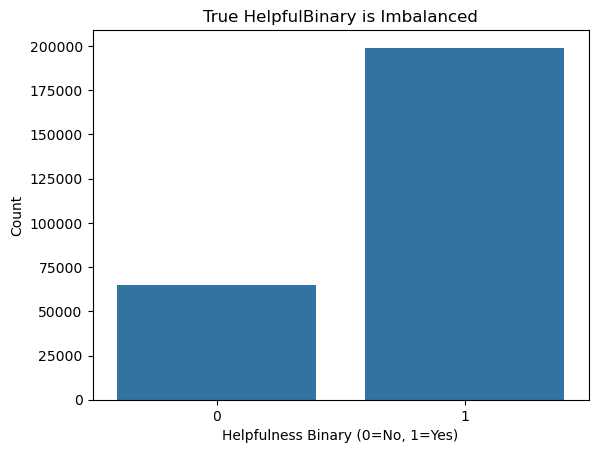

In [29]:
sns.countplot(data=df_labeled, x='HelpfulBinary')
plt.title("True HelpfulBinary is Imbalanced")
plt.xlabel("Helpfulness Binary (0=No, 1=Yes)")
plt.ylabel("Count")
plt.show()


In [30]:
# combine TF-IDF
X_text_sparse = X_text  # TF-IDF is sparse
X_extra_dense = X_extra  # cosine / recency / ratio are dense

# For merging successfully, we transform dense array into sparse format.
X = hstack([X_text_sparse, csr_matrix(X_extra_dense)])


## XGBoost Training for Helpfulness Classification(with dimensionally reduction -- SVD)
We use TruncatedSVD to compress the sparse TF-IDF matrix into a smaller dense feature space, preserving important information while reducing memory and computational costs.  

we apply TruncatedSVD to reduce the dimensionality of sparse TF-IDF features.
TruncatedSVD (Truncated Singular Value Decomposition) compresses a high-dimensional sparse matrix into a lower-dimensional dense matrix while preserving the main variance in the data.
This helps reduce computational cost and improves the stability and efficiency of model training.

We first compress the TF-IDF features into 100 dimensions using TruncatedSVD, and then apply standardization (StandardScaler) to ensure that all features are on the same scale.

Using TruncatedSVD is particularly suitable for text analysis tasks, because TF-IDF matrices are typically sparse, and TruncatedSVD can directly operate on sparse inputs without converting them into dense format, thus avoiding memory issues.




In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

# transform X_extra into sparse
X_extra_sparse = csr_matrix(X_extra)

# merge two sparse matrix
X_sparse_all = hstack([X_text, X_extra_sparse])  # all of them are sparse

# TruncatedSVD + scaling in pipeline
pipeline = make_pipeline(
    TruncatedSVD(n_components=100, random_state=42),
    StandardScaler()  # optional, if needed by XGBoost
)

X_reduced = pipeline.fit_transform(X_sparse_all)


In [32]:
# use X_reduced which is dimension reducted feature to train
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# make processed file
df_X_train = pd.DataFrame(X_train)
df_X_test = pd.DataFrame(X_test)
df_y_train = pd.DataFrame(y_train)
df_y_test = pd.DataFrame(y_test)

# Save train and test set to local CSV files
df_X_train.to_csv('X_train_processed.csv', index=False)
df_X_test.to_csv('X_test_processed.csv', index=False)
df_y_train.to_csv('y_train_processed.csv', index=False)
df_y_test.to_csv('y_test_processed.csv', index=False)

print("Data reformatted for XGBoost and saved to CSV files locally.")


Data reformatted for XGBoost and saved to CSV files locally.


In [11]:
# Upload train/test data to S3
import sagemaker
import boto3

# Initialize SageMaker session
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = "is597-group10"
prefix = "model_training"

# Upload CSVs
X_train_s3_path = sagemaker_session.upload_data(
    path='X_train_processed.csv',
    bucket=bucket,
    key_prefix=f'{prefix}/train'
)

y_train_s3_path = sagemaker_session.upload_data(
    path='y_train_processed.csv',
    bucket=bucket,
    key_prefix=f'{prefix}/train'
)

X_test_s3_path = sagemaker_session.upload_data(
    path='X_test_processed.csv',
    bucket=bucket,
    key_prefix=f'{prefix}/test'
)

y_test_s3_path = sagemaker_session.upload_data(
    path='y_test_processed.csv',
    bucket=bucket,
    key_prefix=f'{prefix}/test'
)

print(f"Training data uploaded to: {X_train_s3_path}")
print(f"Testing data uploaded to: {y_train_s3_path}")
print(f"Testing data uploaded to: {X_test_s3_path}")
print(f"Testing data uploaded to: {y_test_s3_path}")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:172: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[05/14/25 23:01:10] INFO     Found credentials from IAM Role:                                   ]8;id=162083;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=299791;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[05/14/25 23:01:12] INFO     Found credentials from IAM Role:                                   ]8;id=296789;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=375901;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[05/14/25 23:01:13] INFO     Found credentials from IAM Role:                                   ]8;id=963787;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=379726;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Training data uploaded to: s3://is597-group10/model_training/train/X_train_processed.csv
Testing data uploaded to: s3://is597-group10/model_training/train/y_train_processed.csv
Testing data uploaded to: s3://is597-group10/model_training/test/X_test_processed.csv
Testing data uploaded to: s3://is597-group10/model_training/test/y_test_processed.csv


In [34]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix
# calculate weight between HelpfulBinary = 0 and HelpfulBinary = 1 to solve imbalanced problem
neg, pos = np.bincount(y)
scale_pos_weight = neg / pos # weight between HelpfulBinary = 0 and HelpfulBinary = 1

# Train model
model_svd = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=8,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight  # add weight deal with imbalance class
)
model_svd.fit(X_train, y_train)

# Evaluate model
y_svd_pred = model_svd.predict(X_test)
print(classification_report(y_test, y_svd_pred))

              precision    recall  f1-score   support

           0       0.73      0.60      0.66     12887
           1       0.88      0.93      0.90     39912

    accuracy                           0.85     52799
   macro avg       0.81      0.77      0.78     52799
weighted avg       0.84      0.85      0.84     52799



In [37]:
# Save model locally as a file
model_svd.save_model('helpful_svd_xgb_model.json')

object_key = 'model_training/model/helpful_svd_xgb_model.json'
# Upload model to S3
s3.upload_file('helpful_svd_xgb_model.json', bucket_name, object_key)

## XGBoost Training for Helpfulness Classification(without dimensionally reduction)

We use XGBoost to predict the `HelpfulBinary` label. Since the dataset is imbalanced, we apply `scale_pos_weight` to give more importance to the minority class (helpful reviews).


In [34]:
# Train XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
#neg, pos = np.bincount(y) # we do that in previous cells
#scale_pos_weight = neg / pos

# split train and test data
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train XGBoost
model = xgb.XGBClassifier(n_estimators=1000, max_depth=7, learning_rate=0.1, scale_pos_weight=scale_pos_weight)
model.fit(X2_train, y2_train)

# prediction and evaluation
y_pred = model.predict(X2_test)
print(classification_report(y2_test, y_pred))



              precision    recall  f1-score   support

           0       0.55      0.71      0.62     12887
           1       0.90      0.81      0.85     39912

    accuracy                           0.79     52799
   macro avg       0.72      0.76      0.73     52799
weighted avg       0.81      0.79      0.79     52799



NOTE: I try to use n_estimators=1000, max_depth=8, learning_rate=0.1 for this model as well, but kernal die. Therefore, I only can compare these parameter with model_svd n_estimators=1000, max_depth=8, learning_rate=0.1

## Model Evaluation

We evaluate the classifier's performance using precision, recall, and F1-score. The model achieves good accuracy, especially in identifying helpful reviews.


In [35]:
# Evaluate model
y_svd_pred = model_svd.predict(X_test)
print("Evaluate the model with SVD")
print(classification_report(y_test, y_svd_pred))

# prediction and evaluation
y_pred = model.predict(X2_test)
print(classification_report(y2_test, y_pred))

Evaluate the model with SVD
              precision    recall  f1-score   support

           0       0.73      0.60      0.66     12887
           1       0.88      0.93      0.90     39912

    accuracy                           0.85     52799
   macro avg       0.81      0.77      0.78     52799
weighted avg       0.84      0.85      0.84     52799

              precision    recall  f1-score   support

           0       0.55      0.71      0.62     12887
           1       0.90      0.81      0.85     39912

    accuracy                           0.79     52799
   macro avg       0.72      0.76      0.73     52799
weighted avg       0.81      0.79      0.79     52799



### Comparison Between Models With and Without Dimensionality Reduction (TruncatedSVD)

To evaluate the effect of dimensionality reduction, we compared two models:

- **Model 1: With TruncatedSVD (dimensionality reduction)**
- **Model 2: Without dimensionality reduction (using full TF-IDF features)**

| Metric               | With SVD | Without SVD |
|----------------------|----------|-------------|
| Precision (class 0)   | 0.73     | 0.55        |
| Recall (class 0)      | 0.60     | 0.71        |
| F1-score (class 0)    | 0.66     | 0.62        |
| Precision (class 1)   | 0.88     | 0.90        |
| Recall (class 1)      | 0.93     | 0.81        |
| F1-score (class 1)    | 0.90     | 0.85        |
| Macro avg F1-score    | 0.78     | 0.73        |
| Weighted avg F1-score | 0.84     | 0.79        |
| Accuracy              | 0.85     | 0.79        |

---

### Interpretation:

- After applying TruncatedSVD, **the model's overall performance improved**.
- **F1-score**, which balances precision and recall, **increased** after using SVD, meaning the model became better at both identifying helpful reviews and avoiding false positives.
- **Accuracy** also improved from 0.79 to 0.85.
- **Macro average F1-score** (which treats both classes equally) increased, indicating that the model handles both helpful and non-helpful reviews more fairly after dimensionality reduction.
- This shows that applying TruncatedSVD **helped simplify the feature space** without losing important information, and **also reduced overfitting** by removing noisy or redundant features.

### Therefore, we decide to use Model 1 (the one with SVD) to do prediction

#### In data with helpfulnessBinary gound truth, does most representative data more helpful?

In [36]:
# True helpfulness for training data(for most representative data)
high_true_reviews = df_labeled.loc[
    df_labeled.groupby('ProductId')['cosine_avg_sim'].idxmax()
].reset_index(drop=True)
high_true_reviews['HelpfulBinary'].value_counts()

HelpfulBinary
1    20300
0     3528
Name: count, dtype: int64

In [37]:
## for most representative review
print("HelpfulBinary = 1:", len(high_true_reviews[high_true_reviews['HelpfulBinary'] == 1]) / (len(high_true_reviews[high_true_reviews['HelpfulBinary'] == 0]) + len(high_true_reviews[high_true_reviews['HelpfulBinary'] == 1])))
print("HelpfulBinary = 0:", len(high_true_reviews[high_true_reviews['HelpfulBinary'] == 0]) / (len(high_true_reviews[high_true_reviews['HelpfulBinary'] == 0]) + len(high_true_reviews[high_true_reviews['HelpfulBinary'] == 1])))

HelpfulBinary = 1: 0.8519388954171563
HelpfulBinary = 0: 0.14806110458284372


In [38]:
## for all reviews
print("HelpfulBinary = 1:", len(df_labeled[df_labeled['HelpfulBinary'] == 1]) / (len(df_labeled[df_labeled['HelpfulBinary'] == 0]) + len(df_labeled[df_labeled['HelpfulBinary'] == 1])))
print("HelpfulBinary = 0:", len(df_labeled[df_labeled['HelpfulBinary'] == 0]) / (len(df_labeled[df_labeled['HelpfulBinary'] == 0]) + len(df_labeled[df_labeled['HelpfulBinary'] == 1])))

HelpfulBinary = 1: 0.7540389328504923
HelpfulBinary = 0: 0.24596106714950774


#### We found most representative reviews are indeed more helpful than normal reviews

## Predicting Helpfulness for Unlabeled Reviews

We use the trained model_svd to predict whether reviews without any helpfulness votes are likely to be helpful. This simulates a real-world setting where feedback hasn't been collected yet.

### Are Representative Reviews More Helpful?

To verify whether representative reviews are truly more useful, we compare the helpfulness of:
- Most representative reviews
- All reviews
- Random reviews (1 per product)

In [38]:
# Predict Helpfulness for Most representative reviews
high_rep_reviews = df_unlabeled.loc[
    df_unlabeled.groupby('ProductId')['cosine_avg_sim'].idxmax()
].reset_index(drop=True)

# Make TF-IDF feature
X_text_hrep = vectorizer.fit_transform(high_rep_reviews['CleanedText'])

# Other numerical value
X_extra_hrep = high_rep_reviews[['cosine_avg_sim', 'recency_weight']].values


# transform X_extra into sparse
X_extra_hrep_sparse = csr_matrix(X_extra_hrep)

# merge two sparse matrix
X_hrep_sparse_all = hstack([X_text_hrep, X_extra_hrep_sparse])  # all of them are sparse

# TruncatedSVD + scaling in pipeline
pipeline = make_pipeline(
    TruncatedSVD(n_components=100, random_state=42),
    StandardScaler()  # optional, if needed by XGBoost
)

X_hrep_reduced = pipeline.fit_transform(X_hrep_sparse_all)

# Predict
hrep_pred = model_svd.predict(X_hrep_reduced)
high_rep_reviews['PredictedHelpful'] = hrep_pred

In [43]:
# Predict Helpfulness for All Reviews
# only predict for all df_unlabeled

# Make TF-IDF feature
X_text_all = vectorizer.transform(df_unlabeled['CleanedText'].fillna(""))

# Other numerical value
X_extra_all = df_unlabeled[['cosine_avg_sim', 'recency_weight']].fillna(0).values

# Transform X_extra into sparse
X_extra_all_sparse = csr_matrix(X_extra_all)

# Merge two sparse matrix
X_all_sparse = hstack([X_text_all, X_extra_all_sparse])

# Apply the same pipeline (TruncatedSVD + Scaling)
X_all_reduced = pipeline.fit_transform(X_all_sparse)

# Predict
all_pred = model_svd.predict(X_all_reduced)
df_unlabeled['PredictedHelpful_All'] = all_pred


In [44]:
# Predict Helpfulness for Random Reviews (1 per Product)
#

import numpy as np

# Randomly sample 1 review per ProductId
random_reviews = df_unlabeled.groupby('ProductId').apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)

# Make TF-IDF feature
X_text_random = vectorizer.transform(random_reviews['CleanedText'].fillna(""))

# Other numerical value
X_extra_random = random_reviews[['cosine_avg_sim', 'recency_weight']].fillna(0).values

# Transform X_extra into sparse
X_extra_random_sparse = csr_matrix(X_extra_random)

# Merge two sparse matrix
X_random_sparse = hstack([X_text_random, X_extra_random_sparse])

# Apply the same pipeline (TruncatedSVD + Scaling)
X_random_reduced = pipeline.fit_transform(X_random_sparse)

# Predict
random_pred = model_svd.predict(X_random_reduced)
random_reviews['PredictedHelpful_Random'] = random_pred


/tmp/ipykernel_7111/1196998240.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  random_reviews = df_unlabeled.groupby('ProductId').apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)


In [45]:
# 📊 Summarize Predicted Helpfulness Rates

# calculate predict ratio per group
rate_all = df_unlabeled['PredictedHelpful_All'].mean()
rate_random = random_reviews['PredictedHelpful_Random'].mean()
rate_rep = high_rep_reviews['PredictedHelpful'].mean()

# make a DataFrame
summary_df = pd.DataFrame({
    'Type of Review': ['All Reviews', 'Random Review per Product', 'Most Representative Review'],
    'Predicted Helpful Rate': [rate_all, rate_random, rate_rep]
})

print(summary_df)


               Type of Review  Predicted Helpful Rate
0                 All Reviews                0.905235
1   Random Review per Product                0.906284
2  Most Representative Review                0.914828


/tmp/ipykernel_7111/322214116.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Type of Review', y='Predicted Helpful Rate', data=summary_df, palette="viridis")


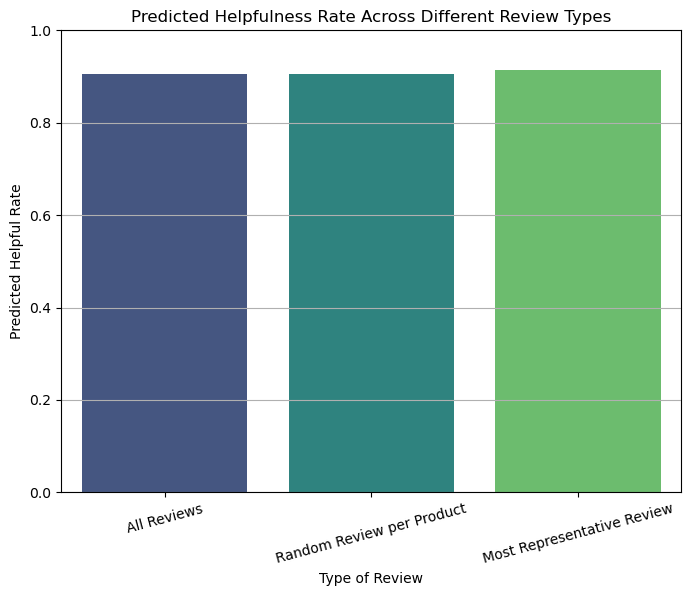

In [46]:
# Visualize Predicted Helpfulness Rates

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.barplot(x='Type of Review', y='Predicted Helpful Rate', data=summary_df, palette="viridis")
plt.title('Predicted Helpfulness Rate Across Different Review Types')
plt.ylabel('Predicted Helpful Rate')
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


### Summary: Are Representative Reviews More Helpful?

Most representative reviews achieved the highest predicted helpful rate (91.48%), compared to random reviews (90.63%) and all reviews (90.52%).

Although the differences are not extremely large, the trend consistently shows that reviews selected based on higher semantic representativeness are slightly more likely to be helpful.

This suggests that the representativeness score, which was based on average cosine similarity and recency weighting, successfully captures meaningful review quality to some extent.  

Additionally, it matches with ground truth of data with HelpfulnessBinary, making the conclusion more convincing.

### Future Work

- Explore deep learning models (e.g., fine-tuned BERT with numeric fusion).
- Incorporate additional metadata (e.g., reviewer reputation or review length).
- Extend the analysis to other domains (e.g., app reviews, hotel feedback).
- Use AWS SageMaker in-built monitoring tools and AWS SageMaker-built models after we get permission.